In [12]:
loan_book = pd.read_csv("/content/mock_loan_book.csv")
loan_book.head()


,company,sector,loan_exposure_eur,enterprise_value_eur,reported_emissions_tco2e,use_reported,sector_default_intensity
0,EnergyCo1,Energy,50000000,200000000,120000.0,True,400
1,EnergyCo2,Energy,30000000,150000000,NaN,False,400
2,AgriCo1,Agriculture,25000000,100000000,40000.0,True,200
3,AgriCo2,Agriculture,15000000,60000000,NaN,False,200
4,TransportCo1,Transport,20000000,80000000,25000.0,True,250


In [13]:
# ----------------------
# 2. Calculate financed emissions
# ----------------------

def financed_emissions(row):
    """
    Apply PCAF logic:
    - If reported emissions available and use_reported == True:
      allocate emissions based on loan exposure / enterprise value
    - Otherwise: use sector default intensity (tCO2e per €m)
    """
    if row["use_reported"] and pd.notnull(row["reported_emissions_tco2e"]):
        return row["loan_exposure_eur"] * (row["reported_emissions_tco2e"] / row["enterprise_value_eur"])
    else:
        return (row["loan_exposure_eur"] / 1_000_000) * row["sector_default_intensity"]

# Apply function to dataset
loan_book["financed_emissions"] = loan_book.apply(financed_emissions, axis=1)

# Preview updated dataset
loan_book[["company", "sector", "loan_exposure_eur", "financed_emissions"]]


,company,sector,loan_exposure_eur,financed_emissions
0,EnergyCo1,Energy,50000000,30000.0
1,EnergyCo2,Energy,30000000,12000.0
2,AgriCo1,Agriculture,25000000,10000.0
3,AgriCo2,Agriculture,15000000,3000.0
4,TransportCo1,Transport,20000000,6250.0
5,TransportCo2,Transport,10000000,2500.0
6,RetailCo1,Retail,40000000,1000.0
7,RetailCo2,Retail,25000000,1250.0
8,TechCo1,Technology,30000000,240.0
9,TechCo2,Technology,20000000,400.0


Portfolio summary by sector:
         sector  financed_emissions
0  Agriculture             13000.0
1       Energy             42000.0
2       Retail              2250.0
3   Technology               640.0
4    Transport              8750.0

Total financed emissions (tCO2e): 66640.0
Total loan exposure (€m): 265.0
Portfolio carbon intensity (tCO2e per €m lent): 251.47


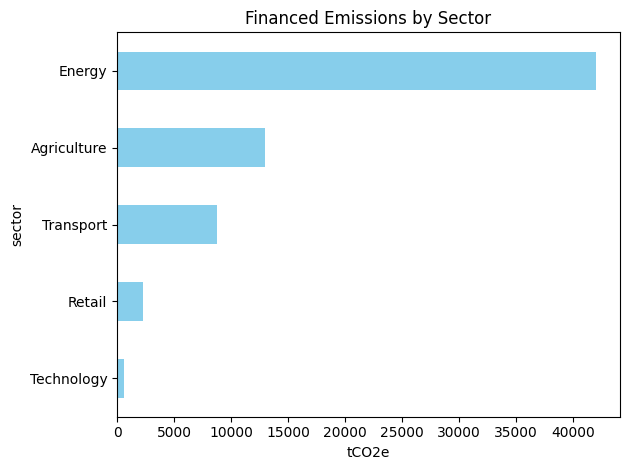

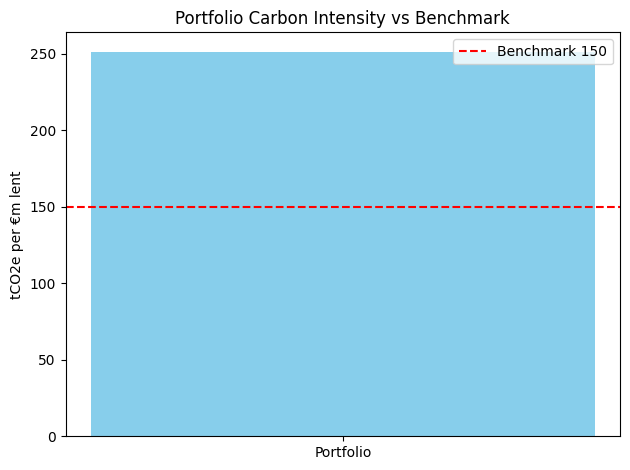

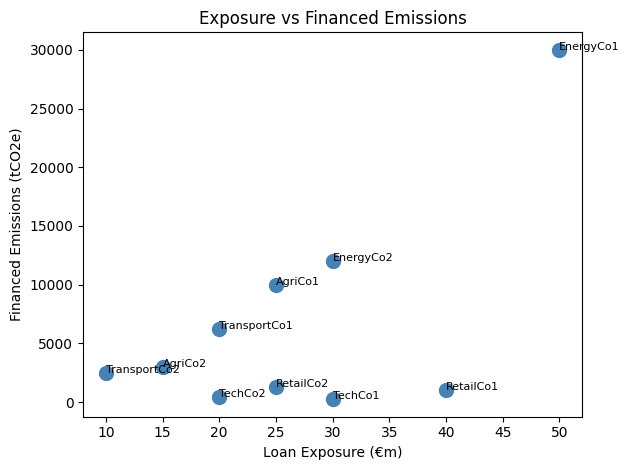

In [14]:
# ----------------------
# 3. Aggregate results
# ----------------------

# Sum emissions by sector
portfolio_summary = loan_book.groupby("sector", as_index=False)["financed_emissions"].sum()

# Totals
total_emissions = loan_book["financed_emissions"].sum()
total_exposure_million = loan_book["loan_exposure_eur"].sum() / 1_000_000
portfolio_intensity = total_emissions / total_exposure_million

print("Portfolio summary by sector:\n", portfolio_summary)
print("\nTotal financed emissions (tCO2e):", round(total_emissions, 2))
print("Total loan exposure (€m):", round(total_exposure_million, 2))
print("Portfolio carbon intensity (tCO2e per €m lent):", round(portfolio_intensity, 2))

# ----------------------
# 4. Visualizations
# ----------------------

import matplotlib.pyplot as plt

# (a) Financed emissions by sector
portfolio_summary.sort_values("financed_emissions", ascending=True).plot(
    kind="barh", x="sector", y="financed_emissions", legend=False,
    title="Financed Emissions by Sector", color="skyblue"
)
plt.xlabel("tCO2e")
plt.tight_layout()
plt.show()

# (b) Portfolio intensity vs benchmark
benchmark_intensity = 150  # mock benchmark (tCO2e/€m)
plt.bar(["Portfolio"], [portfolio_intensity], color="skyblue")
plt.axhline(y=benchmark_intensity, color="red", linestyle="--", label=f"Benchmark {benchmark_intensity}")
plt.ylabel("tCO2e per €m lent")
plt.title("Portfolio Carbon Intensity vs Benchmark")
plt.legend()
plt.tight_layout()
plt.show()

# (c) Scatter: exposure vs financed emissions
plt.scatter(loan_book["loan_exposure_eur"] / 1_000_000, loan_book["financed_emissions"], s=100, color="steelblue")
for i, row in loan_book.iterrows():
    plt.text(row["loan_exposure_eur"] / 1_000_000, row["financed_emissions"], row["company"], fontsize=8)
plt.xlabel("Loan Exposure (€m)")
plt.ylabel("Financed Emissions (tCO2e)")
plt.title("Exposure vs Financed Emissions")
plt.tight_layout()
plt.show()

In [15]:
# ----------------------
# 5. Executive Summary
# ----------------------

print("\n--- EXECUTIVE SUMMARY ---")
print(f"Total financed emissions: {round(total_emissions,2)} tCO2e")
print(f"Portfolio exposure: {round(total_exposure_million,2)} €m")
print(f"Portfolio carbon intensity: {round(portfolio_intensity,2)} tCO2e/€m lent")

# Sector with the largest footprint
top_sector = portfolio_summary.sort_values("financed_emissions", ascending=False).iloc[0]
print(f"Sector hotspot: {top_sector['sector']} ({round(top_sector['financed_emissions'],2)} tCO2e)")



--- EXECUTIVE SUMMARY ---
Total financed emissions: 66640.0 tCO2e
Portfolio exposure: 265.0 €m
Portfolio carbon intensity: 251.47 tCO2e/€m lent
Sector hotspot: Energy (42000.0 tCO2e)
